In [4]:
import pandas as pd
import time
import os
import keras
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential, save_model, load_model

import matplotlib
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow.keras import regularizers

import seaborn as sns

from sklearn.model_selection import KFold
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [5]:

# Useful Constants

# Output classes to learn how to classify
LABELS = [
    "arching_back",
    "head_banging",
    "kicking_legs",
    "rubbing_eye",
    "stretching",
    "sucking_fingers"
]

DATASET_PATH = "C:\\Users\\Yurtsever\\Downloads\\baby_pose_data\\"

X_train_path = DATASET_PATH + "train_test_alphapose\\X_train.txt"
X_test_path = DATASET_PATH + "train_test_alphapose\\X_test.txt"

y_train_path = DATASET_PATH + "train_test_alphapose\\Y_train.txt"
y_test_path = DATASET_PATH + "train_test_alphapose\\Y_test.txt"

n_steps = 20 # 20 timesteps per series

In [6]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    #blocks = int(len(X_) / n_steps)
    
    #X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)

In [7]:
print(X_train)

[[241.87701 310.38177 194.15741 ... 258.68555 317.4331  226.87242]
 [223.84921 313.58362 189.10236 ... 223.72423 311.7373  229.83324]
 [228.3191  319.54797 279.56335 ... 212.78914 317.99655 234.14088]
 ...
 [156.81313 354.2569  251.18188 ... 340.77563 385.9944  556.47565]
 [156.81313 358.75064 257.92252 ... 327.2944  385.9944  556.47565]
 [156.81313 358.75064 253.42876 ... 327.2944   71.43187 601.4131 ]]


In [8]:
X_train.shape

(36820, 36)

In [9]:
#scaler = MinMaxScaler()
#X_train = scalar.fit_transform(X_train)
#X_test = scalar.fit_transform(X_test)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
print(X_train)

[[0.23484372 0.5832023  0.20723258 ... 0.41689944 0.29701    0.3191286 ]
 [0.21706845 0.5880142  0.20132932 ... 0.37268037 0.29279166 0.3233211 ]
 [0.22147572 0.5969777  0.30696902 ... 0.3588497  0.2974273  0.3294207 ]
 ...
 [0.1509714  0.64914024 0.27382535 ... 0.52072686 0.34778702 0.78584343]
 [0.1509714  0.65589356 0.281697   ... 0.5036758  0.34778702 0.78584343]
 [0.1509714  0.65589356 0.27644923 ... 0.5036758  0.11481963 0.8494744 ]]


In [11]:
X_train.shape

(36820, 36)

In [12]:
print(y_test)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]


## Block creation

In [13]:
blocks = int(len(X_train) / 20)
X_train = np.array(np.split(X_train, blocks))
X_train.shape

(1841, 20, 36)

In [14]:
blocks = int(len(X_test) / 20)
X_test = np.array(np.split(X_test, blocks))
X_test.shape

(833, 20, 36)

In [15]:
y_train.shape

(1841, 1)

In [16]:
X_train.shape

(1841, 20, 36)

In [17]:
print(X_train)

[[[0.23484372 0.5832023  0.20723258 ... 0.41689944 0.29701    0.3191286 ]
  [0.21706845 0.5880142  0.20132932 ... 0.37268037 0.29279166 0.3233211 ]
  [0.22147572 0.5969777  0.30696902 ... 0.3588497  0.2974273  0.3294207 ]
  ...
  [0.2153679  0.5948984  0.19170204 ... 0.45037347 0.28143537 0.33153218]
  [0.21086904 0.6114531  0.1965579  ... 0.4382624  0.28542945 0.3338761 ]
  [0.20908628 0.59474635 0.32608867 ... 0.36773956 0.28365034 0.33671972]]

 [[0.22178414 0.5841285  0.19302408 ... 0.4879802  0.28593633 0.32267287]
  [0.22919373 0.586506   0.19732536 ... 0.40158433 0.28856665 0.31954166]
  [0.22635205 0.58698034 0.19598293 ... 0.40655625 0.28665483 0.31946835]
  ...
  [0.19588733 0.6090006  0.32270172 ... 0.35456312 0.2754386  0.34763032]
  [0.19051658 0.6103849  0.31643423 ... 0.35386258 0.27496618 0.34617126]
  [0.09925842 0.5463445  0.2535158  ... 0.43228596 0.27257144 0.3601534 ]]

 [[0.20908628 0.59474635 0.32608867 ... 0.36773956 0.28365034 0.33671972]
  [0.20390652 0.599671

In [18]:
label_encoder = LabelEncoder()
Y_train = np.array(y_train)
Y_train = label_encoder.fit_transform(y_train)

C:\Users\Yurtsever\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [19]:
print(Y_train)

[0 0 0 ... 5 5 5]


In [20]:
label_encoder.classes_

array([0, 1, 2, 3, 4, 5])

In [21]:
Y_train = to_categorical(Y_train)

In [22]:
y_test = to_categorical(y_test)

In [23]:
print(Y_train)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [24]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, y_test), axis=0)

In [25]:
#K-FOLD MODEL

num_folds = 10

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# alphapose 38 --> 36 (18*2)
input_shape = (20, 36)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [26]:
# K-fold Cross Validation model evaluation
fold_no = 1
best_fold = 1.5

for train, test in kfold.split(inputs, targets):
    
  # Define the model architecture
    model = Sequential()
    model.add(LSTM(32, input_shape=(20, 36), dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # input_shape=(20, 50)
    #model.add(LSTM(32, input_shape=(20, 36), dropout=0.2, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
    #model.add(LSTM(16, input_shape=(20, 36), dropout=0.2, recurrent_dropout=0.2, return_sequences=False, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
    model.add(Dense(32, activation='sigmoid'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(Dense(32, activation='sigmoid'))
    #model.add(Dense(32))
    #model.add(Dense(32))
    model.add(Dense(6, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # Define callbacks
    #checkpoint_path = f'./fold_models/{fold_no}'
    #os.mkdir(checkpoint_path)
    
    #keras_callbacks = [
    #ModelCheckpoint(checkpoint_path, monitor='accuracy', save_best_only=True, mode='min')
    #]

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=8,
              epochs=40,
              verbose=1)
    
    filepath = f'./fold_models_new/{fold_no}.h5'
    save_model(model, filepath, save_format='h5')

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # take the fold history that has the best loss for our model 
    if (scores[0] < best_fold):
        best_fold_history = history

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
301/301 [==============================] - 4s 7ms/step - loss: 2.0259 - accuracy: 0.1758
Epoch 2/40
301/301 [==============================] - 2s 6ms/step - loss: 1.6761 - accuracy: 0.3456
Epoch 3/40
301/301 [==============================] - 2s 7ms/step - loss: 1.5312 - accuracy: 0.4031
Epoch 4/40
301/301 [==============================] - 2s 7ms/step - loss: 1.4108 - accuracy: 0.4442
Epoch 5/40
301/301 [==============================] - 2s 7ms/step - loss: 1.3173 - accuracy: 0.5026
Epoch 6/40
301/301 [==============================] - 2s 7ms/step - loss: 1.2711 - accuracy: 0.5034
Epoch 7/40
301/301 [==============================] - 2s 7ms/step - loss: 1.2399 - accuracy: 0.5064
Epoch 8/40
301/301 [==============================] - 2s 7ms/step - loss: 1.1968 - accuracy: 0.5718
Epoch 9/40
301/301 [==============================] - 2s 7ms/step - loss: 1.1769 - accuracy: 0.5443
Epo

dict_keys(['loss', 'accuracy'])


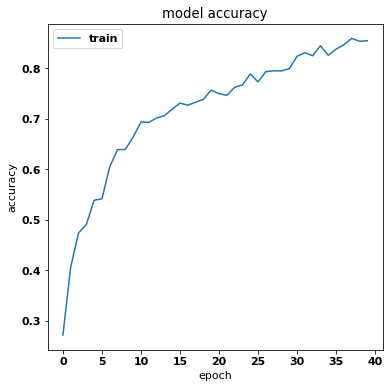

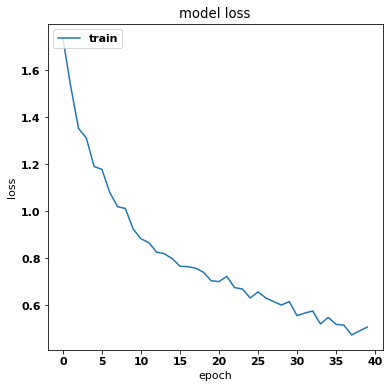

In [27]:
# (Inline plots: )

font = {
    'weight' : 'bold',
    'size'   : 11
}
matplotlib.rc('font', **font)

width = 6
height = 6
plt.figure(figsize=(width, height))


print(best_fold_history.history.keys())
# summarize history for accuracy
plt.plot(best_fold_history.history['accuracy'])
#plt.plot(best_fold_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

font = {
    'weight' : 'bold',
    'size'   : 11
}
matplotlib.rc('font', **font)

width = 6
height = 6
plt.figure(figsize=(width, height))


# summarize history for loss
plt.plot(best_fold_history.history['loss'])
#plt.plot(best_fold_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
y_true = y_test
y_pred = model.predict_classes(X_test)

classes=["arching_back", "head_banging", "kicking_legs", "rubbing_eye", "stretching", "sucking_fingers"]

C:\Users\Yurtsever\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


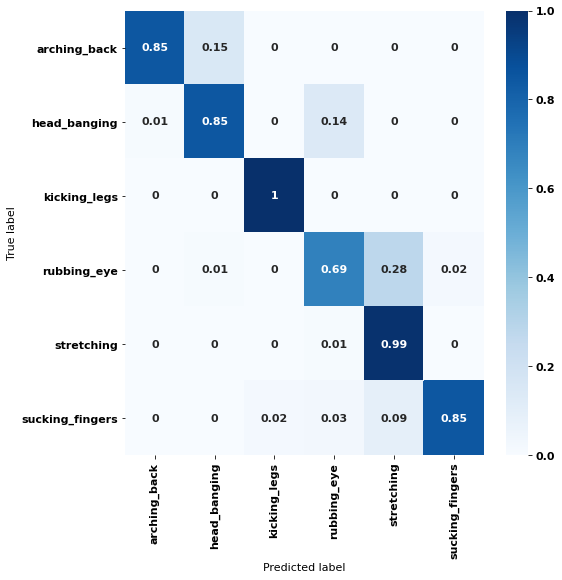

In [29]:
con_mat = tf.math.confusion_matrix(labels=y_true.argmax(axis=1), predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
#load selected model...
# FOLD 8

loaded_model = load_model('./fold_models_new/8.h5')

loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                8832      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 198       
Total params: 11,142
Trainable params: 11,142
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Fit again after selecting best model (fit without train_test split)

# Define callbacks
checkpoint_path = './best_model_new'
os.mkdir(checkpoint_path)

keras_callbacks = [
ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
]

# fit final model.
history = loaded_model.fit(X_train, Y_train, validation_data=(X_test, y_test), epochs=40, batch_size=8, callbacks=keras_callbacks)

Epoch 1/40
231/231 [==============================] - 4s 12ms/step - loss: 0.3483 - accuracy: 0.9071 - val_loss: 0.3595 - val_accuracy: 0.8920

Epoch 00001: val_loss improved from inf to 0.35949, saving model to .\best_model_new
INFO:tensorflow:Assets written to: .\best_model_new\assets
Epoch 2/40
231/231 [==============================] - 2s 7ms/step - loss: 0.3235 - accuracy: 0.9196 - val_loss: 0.3602 - val_accuracy: 0.9016

Epoch 00002: val_loss did not improve from 0.35949
Epoch 3/40
231/231 [==============================] - 2s 7ms/step - loss: 0.3620 - accuracy: 0.9120 - val_loss: 0.4219 - val_accuracy: 0.8956

Epoch 00003: val_loss did not improve from 0.35949
Epoch 4/40
231/231 [==============================] - 2s 8ms/step - loss: 0.3184 - accuracy: 0.9191 - val_loss: 0.3241 - val_accuracy: 0.9232

Epoch 00004: val_loss improved from 0.35949 to 0.32406, saving model to .\best_model_new
INFO:tensorflow:Assets written to: .\best_model_new\assets
Epoch 5/40
231/231 [=============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


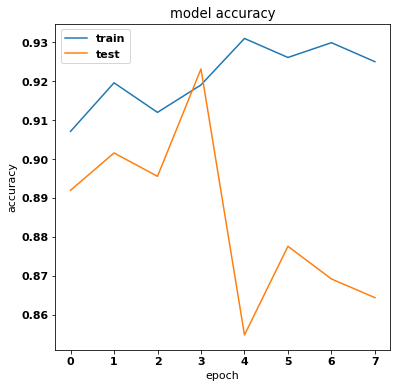

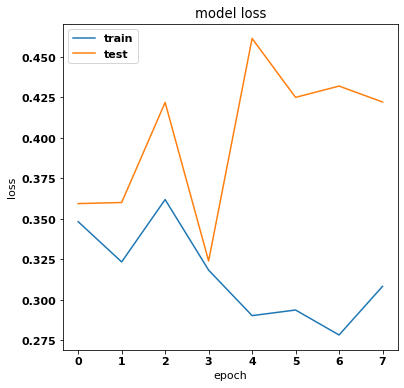

In [32]:
# (Inline plots: )

font = {
    'weight' : 'bold',
    'size'   : 11
}
matplotlib.rc('font', **font)

width = 6
height = 6
plt.figure(figsize=(width, height))


print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

font = {
    'weight' : 'bold',
    'size'   : 11
}
matplotlib.rc('font', **font)

width = 6
height = 6
plt.figure(figsize=(width, height))


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
y_true = y_test
y_pred = loaded_model.predict_classes(X_test)

classes=["arching_back", "head_banging", "kicking_legs", "rubbing_eye", "stretching", "sucking_fingers"]
#classes=["head_banging", "kicking_legs", "rubbing_eye", "stretching", "sucking_fingers"]

C:\Users\Yurtsever\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


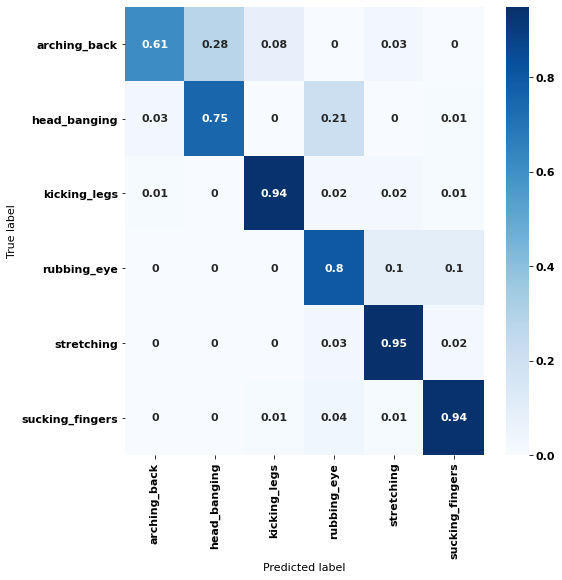

In [34]:
con_mat = tf.math.confusion_matrix(labels=y_true.argmax(axis=1), predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [35]:
y_pred = model.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), np.rint(y_pred.argmax(axis=1)))

In [36]:
print(confusion_matrix)

[[ 60  11   0   0   0   0]
 [  1  98   0  16   0   0]
 [  0   0 156   0   0   0]
 [  0   1   0  86  35   3]
 [  0   0   0   1  99   0]
 [  0   0   6   9  24 227]]


In [37]:
print(y_test)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
